# Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import numpy as np
import matplotlib.pyplot as plt

# EDA

In [2]:
df = pd.read_csv('3_year_recidivism_elaborated_2.csv')
df

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Main Supervising District,Release type: Paroled to Detainer united,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White - Non-Hispanic,Under 25,D Felony,Violent,4JD,Parole,Yes,1
1,2010,2013,White - Non-Hispanic,55 and Older,D Felony,Public Order,7JD,Parole,Yes,1
2,2010,2013,White - Non-Hispanic,25-34,D Felony,Property,5JD,Parole,Yes,1
3,2010,2013,White - Non-Hispanic,55 and Older,C Felony,Drug,8JD,Parole,Yes,1
4,2010,2013,Black - Non-Hispanic,25-34,D Felony,Drug,3JD,Parole,Yes,1
...,...,...,...,...,...,...,...,...,...,...
26015,2015,2018,White - Hispanic,25-34,C Felony,Violent,Not Mentioned,Discharged End of Sentence,Yes,0
26016,2015,2018,White - Non-Hispanic,25-34,D Felony,Property,5JD,Paroled to Detainer,No,0
26017,2015,2018,Black - Non-Hispanic,Under 25,Aggravated Misdemeanor,Violent,1JD,Discharged End of Sentence,Yes,0
26018,2015,2018,White - Non-Hispanic,Under 25,D Felony,Drug,5JD,Parole,No,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Fiscal Year Released                      26020 non-null  int64 
 1   Recidivism Reporting Year                 26020 non-null  int64 
 2   Race - Ethnicity                          26020 non-null  object
 3   Age At Release                            26020 non-null  object
 4   Convicting Offense Classification         26020 non-null  object
 5   Convicting Offense Type                   26020 non-null  object
 6   Main Supervising District                 26020 non-null  object
 7   Release type: Paroled to Detainer united  26020 non-null  object
 8   Part of Target Population                 26020 non-null  object
 9   Recidivism - Return to Prison numeric     26020 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.0+ MB


Looking pretty good - no null values! One thing to note, though, is that with the exception of the year columns, all the data is categorical, which means it needs to be encoded. Also going to drop the year columns because they're not relevant to the model we want to create: one that can predict recidivism based on the *person*.

In [4]:
df.drop(['Fiscal Year Released', 'Recidivism Reporting Year'], axis=1, inplace=True)

This next bit is pretty straightforward: split the data into train/test/validation sets. The only slightly unusual thing we're going to do is to create new DataFrames to store the train/test/validation data so that we can come back and do some analysis at the end.

In [5]:
x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

enc = OneHotEncoder(sparse=False)
encoded_x = enc.fit_transform(x)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

train_df = pd.DataFrame([])
combo_df = pd.DataFrame([])
test_df = pd.DataFrame([])
valid_df = pd.DataFrame([])

for train_index, combo_index in sss.split(encoded_x, y):
    train_x, combo_x = encoded_x[train_index], encoded_x[combo_index]
    train_y, combo_y = y[train_index], y[combo_index]
    train_df = train_df.append(df.iloc[train_index])
    combo_df = combo_df.append(df.iloc[combo_index])
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for test_index, valid_index in sss.split(combo_x, combo_y):
    test_x, valid_x = combo_x[test_index], combo_x[valid_index]
    test_y, valid_y = combo_y[test_index], combo_y[valid_index]
    test_df = test_df.append(combo_df.iloc[test_index])
    valid_df = valid_df.append(combo_df.iloc[valid_index])

Last but not least we define a couple helper methods.

In [6]:
best_model = {'acc': 0}

# Tracks model with highest accuracy
def update_best_model(acc, name, model, params):
    if (acc > best_model['acc']):
        best_model['acc'] = acc
        best_model['name'] = name
        best_model['model'] = model
        best_model['params'] = params

# Performs a grid search on a passed-in classifier
def run_grid_search(folds, params, clf, name):
    gscv = GridSearchCV(clf, params, cv=folds)
    gscv.fit(train_x, train_y)
    acc = accuracy_score(test_y, gscv.predict(test_x))
    update_best_model(acc, name, gscv, gscv.best_params_)

# Algorithm Testing

## KNN

In [7]:
folds = 10
params = {'n_neighbors': list(range(3, 16))}

run_grid_search(folds, params, KNeighborsClassifier(), 'KNN')

## Trees

### Decision Tree

In [8]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8]}

run_grid_search(folds, params, DecisionTreeClassifier(), 'Decision Tree')

### Random Forest

In [9]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8],
         'n_estimators': [10, 20, 30, 40]}

run_grid_search(folds, params, RandomForestClassifier(), 'Random Forest')

## Logistic Regression

In [10]:
folds = 10
params = {'penalty': ['l1', 'l2'],
             'C': [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]}

run_grid_search(folds, params, LogisticRegression(solver='liblinear'), 'Logistic Regression')

## DNN

In [11]:
train_x = tf.dtypes.cast(train_x, tf.float64)
test_x = tf.dtypes.cast(test_x, tf.float64)
valid_x = tf.dtypes.cast(valid_x, tf.float64)

train_y = tf.dtypes.cast(train_y, tf.int64)
test_y = tf.dtypes.cast(test_y, tf.int64)
valid_y = tf.dtypes.cast(valid_y, tf.int64)

In [12]:
%load_ext tensorboard

In [13]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40, 80, 120]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([1, 2, 3]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

### Notes

- Adding loss weights doesn't really affect accuracy but *can* massively decrease loss, for some reason. [0.2, 3] reduces loss from ~0.5 all the way down to 0.1-0.12 range
- Deriving the loss weights from the dataset itself doesn't seem to make much of a difference
- Messing around with the loss function doesn't really do much

In [14]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten())

  for i in range(hparams[HP_NUM_LAYERS]):
        model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu))
        
  model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
  model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
#       loss_weights=[0.2,3],
  )
    
  model.fit(train_x, train_y, epochs=20) 
  _, accuracy = model.evaluate(test_x, test_y)
    
  update_best_model(accuracy, 'DNN', model, hparams)

  return accuracy

In [15]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [16]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for num_layers in HP_NUM_LAYERS.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_NUM_LAYERS: num_layers,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 40, 'dropout': 0.1, 'optimizer': 'adam', 'num_layers': 1}
Epoch 1/20
570/570 [==============================] - 1s 2ms/step - loss: 0.6128 - accuracy: 0.6693
Epoch 2/20
570/570 [==============================] - 1s 2ms/step - loss: 0.5992 - accuracy: 0.6738
Epoch 3/20
570/570 [==============================] - 1s 1ms/step - loss: 0.5947 - accuracy: 0.6792
Epoch 4/20
570/570 [==============================] - 1s 1ms/step - loss: 0.5925 - accuracy: 0.6778
Epoch 5/20
570/570 [==============================] - 1s 2ms/step - loss: 0.5902 - accuracy: 0.6808
Epoch 6/20
570/570 [==============================] - 1s 1ms/step - loss: 0.5884 - accuracy: 0.6804
Epoch 7/20
570/570 [==============================] - 1s 1ms/step - loss: 0.5871 - accuracy: 0.6816: 0s - loss: 0.5836 - accu
Epoch 8/20
570/570 [==============================] - 1s 1ms/step - loss: 0.5856 - accuracy: 0.6879
Epoch 9/20
570/570 [==============================] - 1s 1ms/step - loss: 0.

In [17]:
%tensorboard --logdir logs/hparam_tuning --host localhost

Reusing TensorBoard on port 6006 (pid 13816), started 3 days, 1:59:19 ago. (Use '!kill 13816' to kill it.)

# Results

In [18]:
print('Best Model:', best_model['name'], '\nAccuracy:', best_model['acc']) 

if (best_model['name'] == 'DNN'):
    print('Parameters:', best_model['params'].values())
else:
    print('Parameters:', best_model['params'])

Best Model: DNN 
Accuracy: 0.679989755153656
Parameters: dict_values([80, 0.2, 'sgd', 1])


Now, let's test our best model against our validation set and see how it does.

In [19]:
prediction = best_model['model'].predict(valid_x)
if (best_model['name'] == 'DNN'):
    prediction = np.argmax(prediction, axis=1)
    _, valid_acc = best_model['model'].evaluate(valid_x, valid_y)
else:
    valid_acc = accuracy_score(valid_y, prediction)

valid_acc

122/122 [==============================] - 0s 703us/step - loss: 0.5931 - accuracy: 0.6769


0.676915168762207

Not great, unfortunately. Better than guessing, though! Next up we'll do some checking to see how how much of a factor ethnicity is in our model. What we're going to do is pretty simple: we're going to replace the old `is_recid` column in `valid_df` with our predicted values in a new `predict_df`. Then, we'll check out how the proportions stack up relative to the spread of ethnicity from the entire original dataset.

In [20]:
def get_diff_dict(column):
    predict_df = valid_df.copy(deep=True)   
    predict_df[column] = prediction

    yes_predict_df = predict_df[predict_df[column] == 1]
    yes_valid_df = valid_df[valid_df[column] == 1]

    no_predict_df = predict_df[predict_df[column] == 0]
    no_valid_df = valid_df[valid_df[column] == 0]

    return {'Validation Set': valid_df, 'Prediction Set': predict_df,
              'Validation where Recidivism=True': yes_valid_df, 'Prediction where Recidivism=True': yes_predict_df,
              'Validation where Recidivism=False': no_valid_df, 'Prediction where Recidivism=False': no_predict_df}
    
    
diff_dict = get_diff_dict('Recidivism - Return to Prison numeric')
diff_values = list(diff_dict.values())

<function matplotlib.pyplot.show(close=None, block=None)>

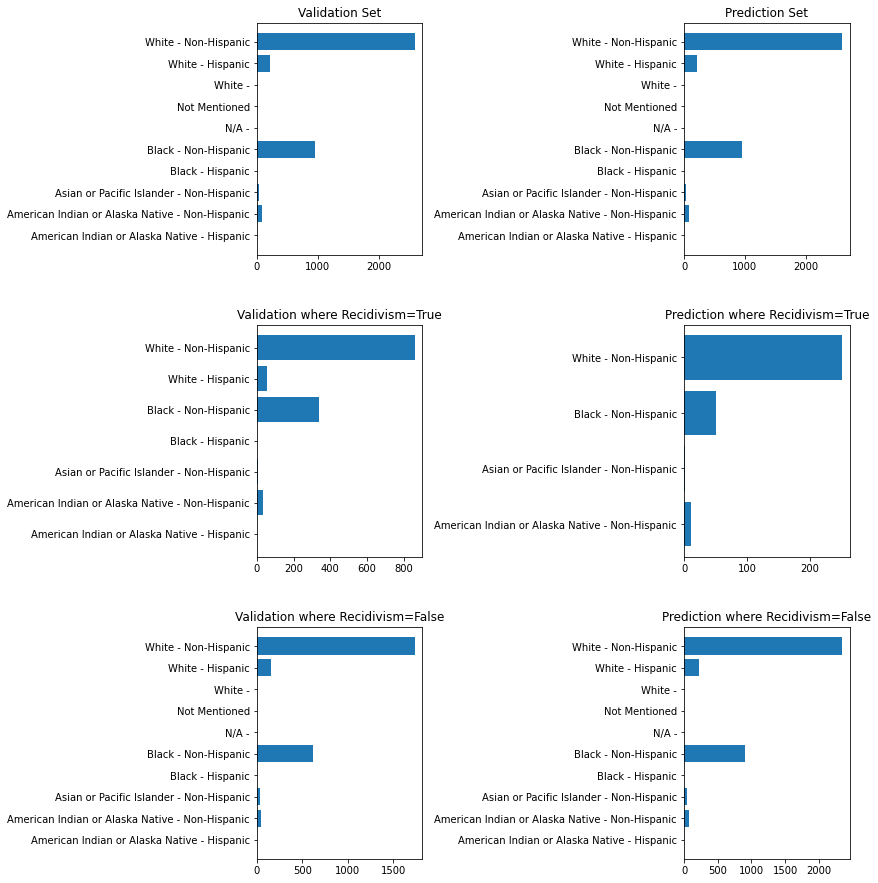

In [21]:
fig = plt.figure(figsize=(12, 8))
i = 1
for k, v in diff_dict.items():
    ax = fig.add_subplot(3,2,i)
    ax.barh(v.sort_values('Race - Ethnicity')['Race - Ethnicity'].unique(), v.sort_values('Race - Ethnicity')['Race - Ethnicity'].value_counts(sort=False))
    ax.set_title(k)
    i += 1
fig.tight_layout()
plt.subplots_adjust(top=1.5)
plt.show

In [22]:
pd.options.display.float_format = '{:.2%}'.format
def compare_ethnic_spread(base_df, hyp_df):
    base_ethnicity_spread = df['Race - Ethnicity'].value_counts(normalize=True)
    hyp_ethnicity_spread = hyp_df['Race - Ethnicity'].value_counts(normalize=True)

    
    print(
'''                          ACTUAL
{}\n--------------------------------------------------------
                        PREDICTED
{}\n--------------------------------------------------------
                        DIFFERENCE'''.format(base_ethnicity_spread, hyp_ethnicity_spread))
    
    diff = dict()
    for race in hyp_df['Race - Ethnicity'].unique():
        diff[race] = hyp_ethnicity_spread[race] - base_ethnicity_spread[race]
        
    print("\n".join("{:48}  {:>6.2%}".format(k, v) for k, v in diff.items()))

In [23]:
print("\t\t\tUNFILTERED\n")
compare_ethnic_spread(diff_values[0], diff_values[1])

			UNFILTERED

                          ACTUAL
White - Non-Hispanic                              67.58%
Black - Non-Hispanic                              23.48%
White - Hispanic                                   5.85%
American Indian or Alaska Native - Non-Hispanic    1.93%
Asian or Pacific Islander - Non-Hispanic           0.74%
Black - Hispanic                                   0.14%
Not Mentioned                                      0.12%
American Indian or Alaska Native - Hispanic        0.08%
White -                                            0.05%
Asian or Pacific Islander - Hispanic               0.02%
N/A -                                              0.02%
Black -                                            0.01%
Name: Race - Ethnicity, dtype: float64
--------------------------------------------------------
                        PREDICTED
White - Non-Hispanic                              66.38%
Black - Non-Hispanic                              24.52%
White - Hispanic        

In [24]:
print("\t\t    RECIDIVISM == TRUE\n")
compare_ethnic_spread(diff_values[2], diff_values[3])

		    RECIDIVISM == TRUE

                          ACTUAL
White - Non-Hispanic                              67.58%
Black - Non-Hispanic                              23.48%
White - Hispanic                                   5.85%
American Indian or Alaska Native - Non-Hispanic    1.93%
Asian or Pacific Islander - Non-Hispanic           0.74%
Black - Hispanic                                   0.14%
Not Mentioned                                      0.12%
American Indian or Alaska Native - Hispanic        0.08%
White -                                            0.05%
Asian or Pacific Islander - Hispanic               0.02%
N/A -                                              0.02%
Black -                                            0.01%
Name: Race - Ethnicity, dtype: float64
--------------------------------------------------------
                        PREDICTED
White - Non-Hispanic                              79.87%
Black - Non-Hispanic                              16.29%
American Indi

In [25]:
print("\t\t    RECIDIVISM == FALSE\n")
compare_ethnic_spread(diff_values[4], diff_values[5])

		    RECIDIVISM == FALSE

                          ACTUAL
White - Non-Hispanic                              67.58%
Black - Non-Hispanic                              23.48%
White - Hispanic                                   5.85%
American Indian or Alaska Native - Non-Hispanic    1.93%
Asian or Pacific Islander - Non-Hispanic           0.74%
Black - Hispanic                                   0.14%
Not Mentioned                                      0.12%
American Indian or Alaska Native - Hispanic        0.08%
White -                                            0.05%
Asian or Pacific Islander - Hispanic               0.02%
N/A -                                              0.02%
Black -                                            0.01%
Name: Race - Ethnicity, dtype: float64
--------------------------------------------------------
                        PREDICTED
White - Non-Hispanic                              65.21%
Black - Non-Hispanic                              25.24%
White - Hisp